In [1]:
# Run this to build or rebuild the dataset - on Google Colab
# !cp drive/MyDrive/icl_data/cutouts.hdf ./cutouts.hdf
# !tfds build drive/MyDrive/icl_data/hsc_icl/ --overwrite
# !cp -r /root/tensorflow_datasets drive/MyDrive/icl_data/

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

2023-03-30 15:11:15.471361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/z5214005/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Retrieve the pre-prepared data from Google Drive and put in a place that tfds 
# can see - for Google Colab
#!cp -r drive/MyDrive/icl_data/tensorflow_datasets /root/

In [4]:
ds = tfds.load('hsc_icl', split='train')

2023-03-30 15:11:21.954325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf.Tensor(1680, shape=(), dtype=int16)


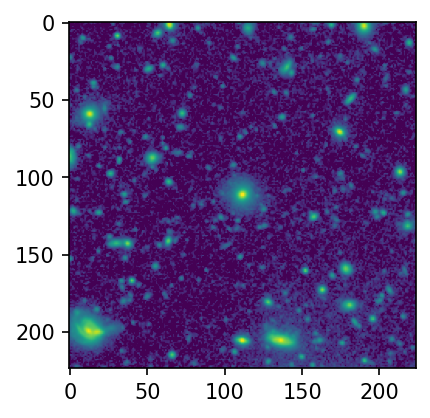

In [5]:
# Display an example from the dataset
from astropy.visualization import ImageNormalize, LogStretch
import matplotlib.pyplot as plt

for example in ds.take(1):
  norm = ImageNormalize(vmin=0, vmax=10, stretch=LogStretch())
  plt.figure(figsize=(3,3), dpi=150)
  plt.imshow(example['image'], norm=norm)
  print(example['id'])
  plt.show()

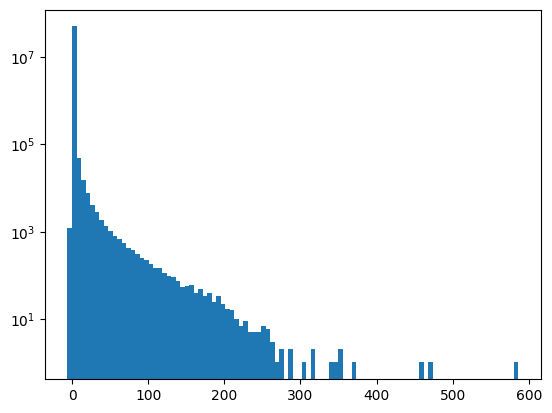

In [6]:
# Check the distributions
cutouts = []
for entry in ds.take(1000):
  cutouts.append(entry['image'])

cutouts = np.stack(cutouts)

plt.hist(cutouts.flatten(), 100)
plt.yscale('log')
plt.show()

0.02337745212561952


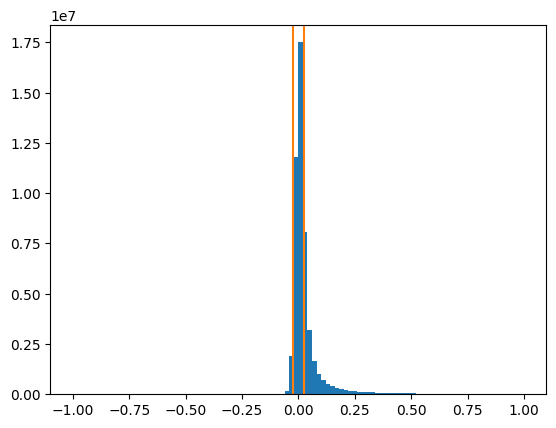

In [7]:
# Display the standard deviation
from astropy.stats import mad_std

plt.hist(cutouts.flatten(), 100, range=[-1,1])
sigma = mad_std(cutouts.flatten())
print(sigma)
plt.axvline(sigma, color='C1')
plt.axvline(-sigma, color='C1')
plt.show()

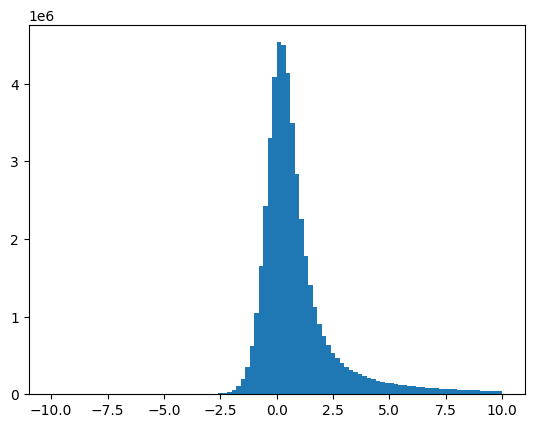

In [8]:
# Rescale by the standard deviation
plt.hist(cutouts.flatten()/sigma, 100, range=[-10,10])
plt.show()

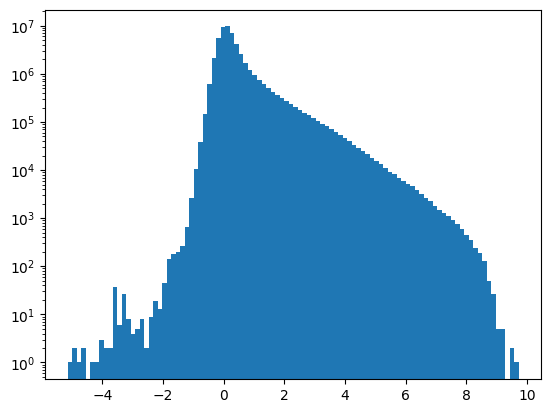

In [9]:
# Apply range compression to suppress the high amplitude values
plt.hist(np.arcsinh(cutouts.flatten()/sigma/3), 100)
plt.yscale('log')
plt.show()

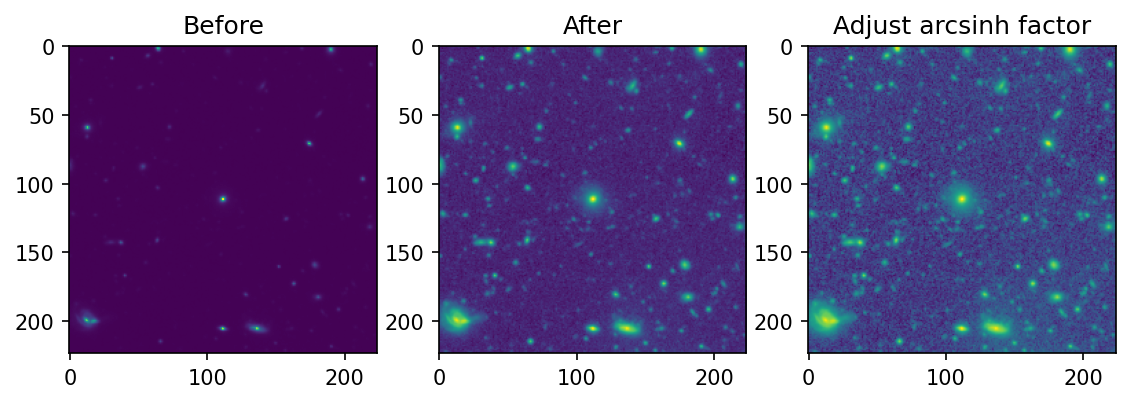

In [10]:
plt.figure(figsize=(9,3), dpi=150)
plt.subplot(131) 
plt.imshow(cutouts[0]/sigma)
plt.title('Before')
plt.subplot(132)
plt.imshow(np.arcsinh(cutouts[0]/sigma/3))
plt.title('After')
plt.subplot(133)
plt.imshow(np.arcsinh(cutouts[0]/sigma))
plt.title('Adjust arcsinh factor')
plt.show()

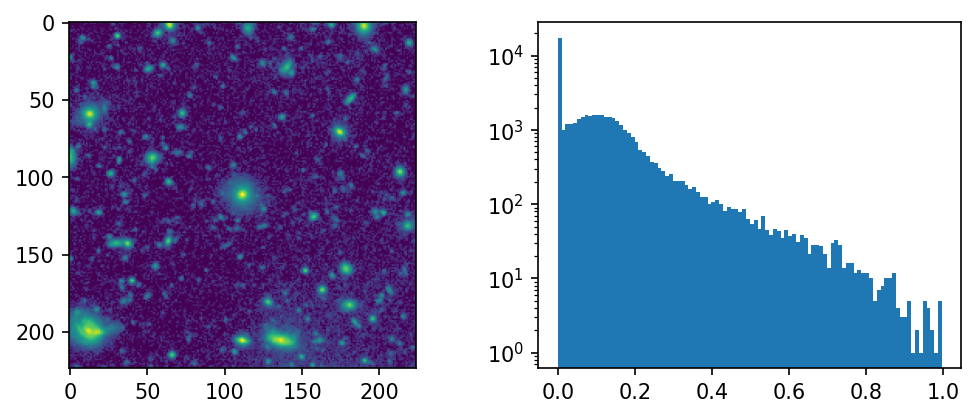

In [11]:
# This is what astropy's ImageNormalize is doing
stretch = LogStretch()
vmax = 10
clip_and_norm = np.clip(np.true_divide(cutouts[0], vmax), 0.0, 1.0)
plt.figure(figsize=(8,3), dpi=150)
plt.subplot(121)
plt.imshow(stretch(clip_and_norm))
plt.subplot(122)
plt.hist(stretch(clip_and_norm).flatten(), 100)
plt.yscale('log')
plt.show()

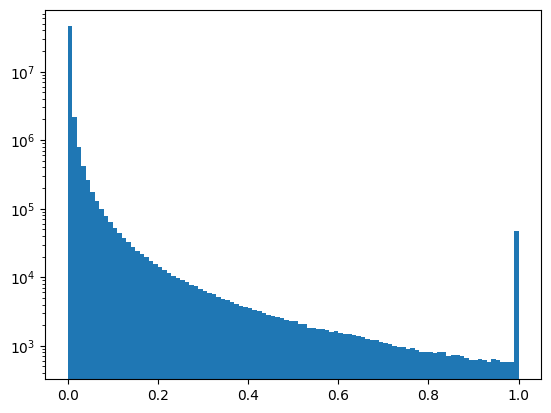

In [12]:
# Trying out some random normalization stuff
vmax = 10

remapped = np.clip(np.true_divide(cutouts, vmax), 0.0, 1.0)
plt.hist(remapped.flatten(), 100)
plt.yscale('log')
plt.show()

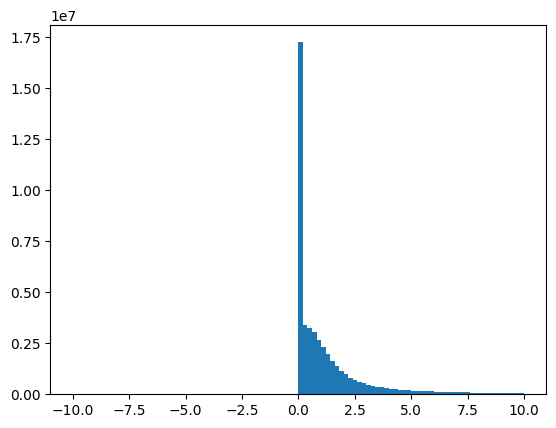

In [13]:
sigma_with_clip = mad_std(remapped.flatten())
plt.hist(remapped.flatten()/sigma_with_clip, 100, range=[-10,10])
plt.show()

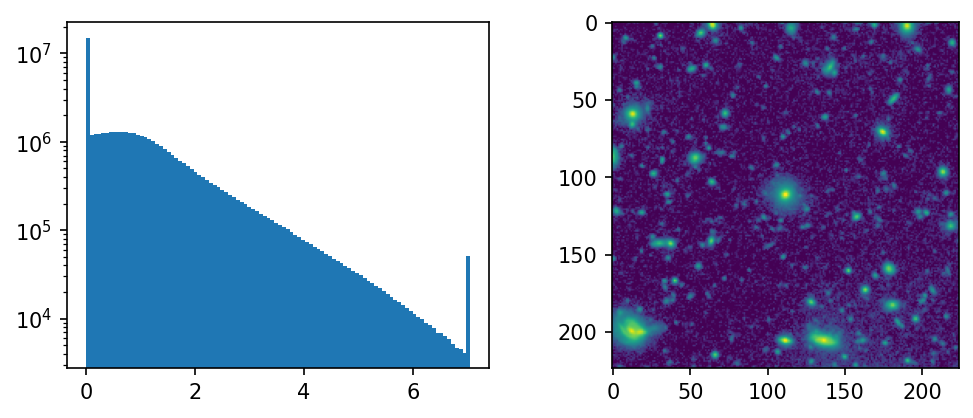

In [14]:
# Stretch the values
plt.figure(figsize=(8,3), dpi=150)
plt.subplot(121)
plt.hist(np.arcsinh(remapped.flatten()/sigma_with_clip), 100)
plt.yscale('log')
plt.subplot(122)
plt.imshow(np.arcsinh(remapped[0]/sigma_with_clip))
plt.show()

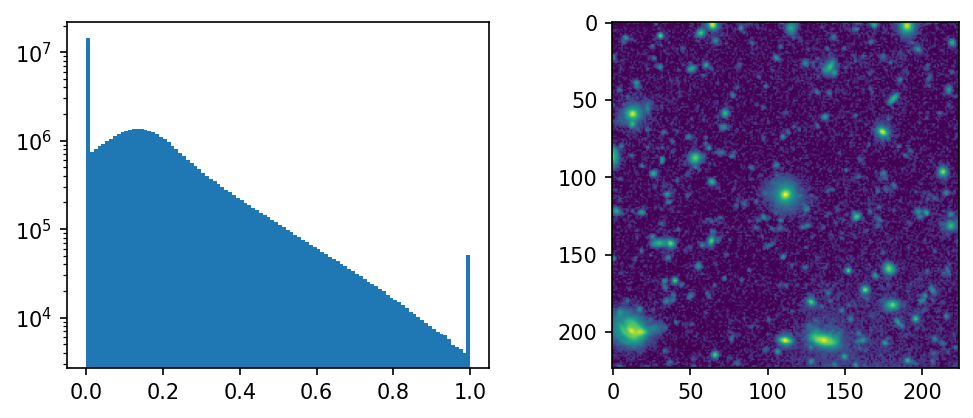

In [15]:
# Another log stretch (y = log(ax+1)/log(a+1)). This is the log stretch that astropy uses
stretched = np.multiply(remapped, 1000.0)
stretched = np.add(stretched, 1.0)
stretched = np.log(stretched)
stretched = np.true_divide(stretched, np.log(1000.0 + 1.0))

plt.figure(figsize=(8,3), dpi=150)
plt.subplot(121)
plt.hist(stretched.flatten(), 100)
plt.yscale('log')
plt.subplot(122)
plt.imshow(stretched[0])
plt.show()

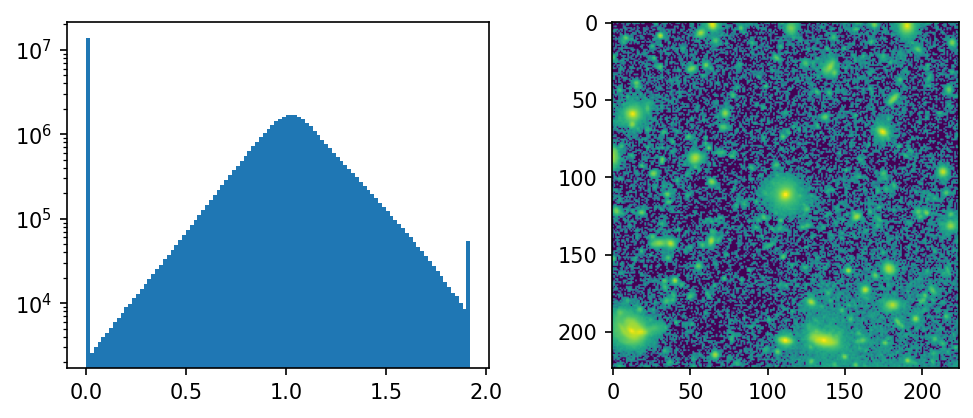

In [16]:
# Another anotger log stretch (y = log(ax+1)/log(a+1)), but also dividing by standard deviation
stretched = np.multiply(remapped / sigma_with_clip, 1000.0)
stretched = np.add(stretched, 1.0)
stretched = np.log(stretched)
stretched = np.true_divide(stretched, np.log(1000.0 + 1.0))

plt.figure(figsize=(8,3), dpi=150)
plt.subplot(121)
plt.hist(stretched.flatten(), 100)
plt.yscale('log')
plt.subplot(122)
plt.imshow(stretched[0])
plt.show()

0.01735862259283717


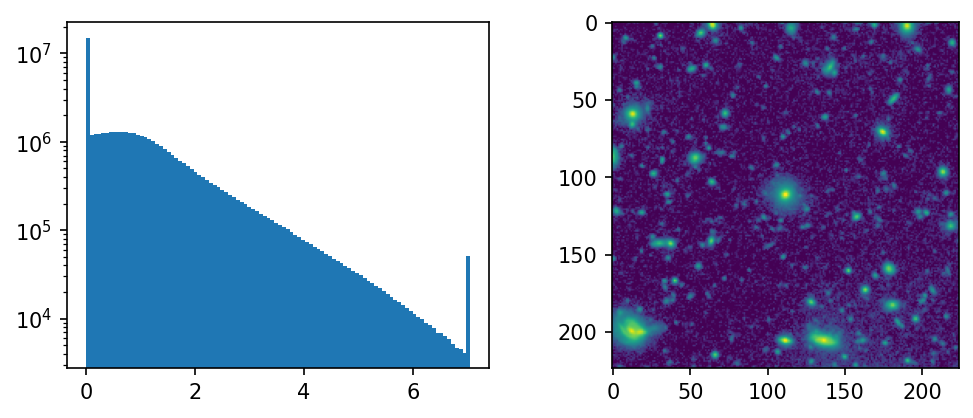

In [17]:
# Try modified arcsinh stretch without remapping the values from 0 to 1
clipped = np.clip(cutouts, 0.0, 10.0)
sigma_with_clip = mad_std(clipped.flatten())
print(sigma_with_clip)

plt.figure(figsize=(8,3), dpi=150)
plt.subplot(121)
plt.hist(np.arcsinh(clipped.flatten()/sigma_with_clip), 100)
plt.yscale('log')
plt.subplot(122)
plt.imshow(np.arcsinh(clipped[0]/sigma_with_clip))
plt.show()
